In [ ]:
# Daily RL State Vector Display
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- 1. SIMULATION SETUP ---

# --- DEFINE FILE PATHS AND DATES ---
WEATHER_FILE_PATH = r"D:\Final-Year-Project\env_trails\weather\RTRL1301.WTH" 
SOIL_FILE_PATH = r"D:\Final-Year-Project\env_trails\MY_GENERATED_SOIL.SOL"
SOIL_ID = "SG12387893"
PLANTING_DATE = datetime(1956, 6, 15)

# --- Load DSSAT Objects ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

# --- Configure Management ---
field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]
initial_values_table = [(depth, 0.35, 1.5, 1.5) for depth in soil_depths]
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

irrigation_events = [filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=day), irop='IR001', irval=5) for day in range(90)]
irrigation = filex.Irrigation(table=irrigation_events)

simulation_controls = filex.SimulationControls(
    general=filex.SCGeneral(sdate=PLANTING_DATE),
    options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
    methods=filex.SCMethods(infil='S'),
    management=filex.SCManagement(irrig='A', ferti='N', resid='N', harvs='M'),
    outputs=filex.SCOutputs(grout='Y', waout='Y', niout='Y')
)
print("✅ Management files configured.")

# --- 2. RUN SIMULATION ---
dssat_output = None
try:
    workspace = os.path.join("dummy", "dssat_state_run")
    os.makedirs(workspace, exist_ok=True)
    
    shutil.copy(WEATHER_FILE_PATH, workspace)
    shutil.copy(SOIL_FILE_PATH, workspace)
    
    dssat = DSSAT(workspace)
    print(f"🚀 Running simulation in: {workspace}")
    
    results = dssat.run_treatment(
        field=field, cultivar=cultivar, planting=planting,
        initial_conditions=initial_conditions, irrigation=irrigation,
        simulation_controls=simulation_controls
    )
    print("\n--- SIMULATION COMPLETE ---")
    dssat_output = dssat.output_tables

except Exception as e:
    print(f"❌ An error occurred during the DSSAT run: {e}")


# --- 3. VISUALIZE THE RESULTS ---

if dssat_output and 'PlantGro' in dssat_output:
    print("\n--- Generating Growth Comparison Plot ---")
    
    # We will just use the irrigated run for this visualization
    irrigated_df = dssat_output["PlantGro"].set_index('DAP')
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot Leaf Weight (LWAD)
    irrigated_df['LWAD'].plot(label='Leaf Dry Weight (Irrigated)', color='blue', linewidth=2)
    
    # --- NEW SECTION: ANNOTATE GROWTH STAGES ---
    # Define a mapping from DSSAT growth stage codes to readable names
    stage_map = {
        1: 'Emergence',
        2: 'End Juvenile',
        3: 'Panicle Init.',
        4: 'End Leaf Growth',
        5: 'Flowering',
        6: 'Start Grain Fill',
        7: 'Maturity'
    }

    # Find the days where the growth stage changes
    stage_changes = irrigated_df[irrigated_df['GSTD'].diff() != 0]

    # Add a vertical line and text for each stage change
    for dap, row in stage_changes.iterrows():
        stage_code = int(row['GSTD'])
        if stage_code in stage_map and dap > 0: # Exclude the initial state at DAP 0
            stage_name = stage_map[stage_code]
            plt.axvline(x=dap, color='gray', linestyle='--', linewidth=0.8)
            # Position the text on the plot
            plt.text(dap + 1, plt.ylim()[1] * 0.9, stage_name, rotation=90, verticalalignment='top', color='dimgray', fontsize=10)
    # --- END OF NEW SECTION ---

    # Add labels and title for clarity
    plt.xlabel("Days After Planting (DAP)", fontsize=14)
    plt.ylabel("Leaf Dry Weight (kg/ha)", fontsize=14)
    plt.title("Sorghum Leaf Growth and Development Stages", fontsize=16, weight='bold')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    print("✅ Plot generated successfully.")

else:
    print("\nCould not generate plot because the simulation failed.")



d:\Final-Year-Project\.venv\Lib\site-packages\DSSATTools\__init__.py:105: DeprecationWarning: DSSATTools version 3.0.0 is a major upgrade and will not be backwards compatible with previous versions. If you are running code that was developed  using a previous DSSATTools version, then install DSSATTools version 2.1.6
  warnings.warn(


✅ Management files configured.
dummy\dssat_state_run created.
🚀 Running simulation in: dummy\dssat_state_run

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1  65 106 16357  7506   501    31   417   268     0   -99      0  186

--- SIMULATION COMPLETE ---

--- Constructing Daily RL State Vector ---

--- Complete Daily State Vector (Planting to Harvest) ---
     days_after_planting  phenological_stage  leaf_area_index  total_biomass  \
0                      0                   0             0.00              0   
1                      1                   0             0.00              0   
2                      2                   0             0.00              0   
3                      3                   0             0.00              0   
4                      4                   0             0.00              0   
5                      5                 

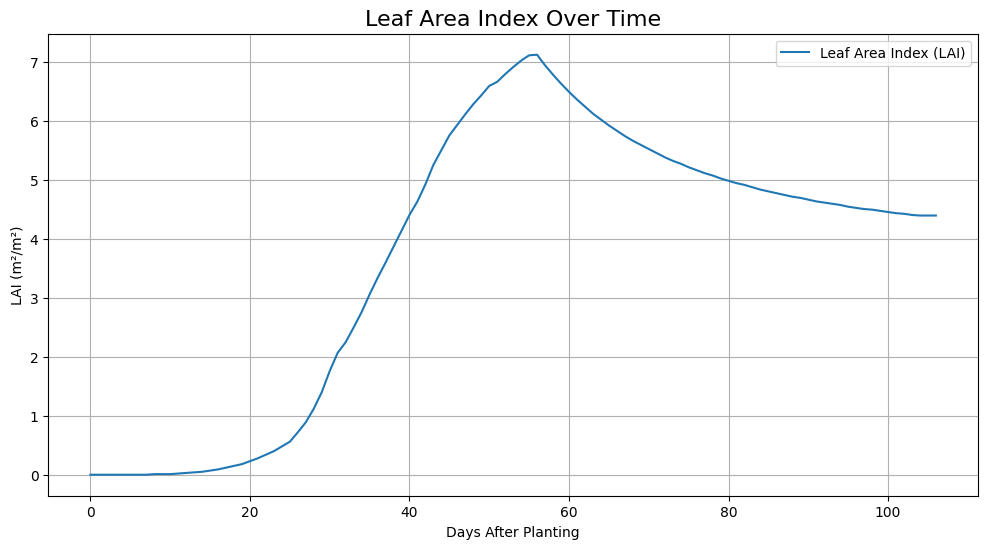

In [1]:
# Daily RL State Vector Display
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- 1. SIMULATION SETUP ---

# --- DEFINE FILE PATHS AND DATES ---
WEATHER_FILE_PATH = r"D:\Final-Year-Project\env_trails\weather\CHEN1301.WTH" 
SOIL_FILE_PATH = r"D:\Final-Year-Project\env_trails\MY_GENERATED_SOIL.SOL"
SOIL_ID = "SG12387893"
PLANTING_DATE = datetime(2013, 6, 15)

# --- Load DSSAT Objects ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

# --- Configure Management ---
field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]
initial_values_table = [(depth, 0.35, 1.5, 1.5) for depth in soil_depths]
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

irrigation_events = [filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=day), irop='IR001', irval=5) for day in range(90)]
irrigation = filex.Irrigation(table=irrigation_events)

simulation_controls = filex.SimulationControls(
    general=filex.SCGeneral(sdate=PLANTING_DATE),
    options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
    methods=filex.SCMethods(infil='S'),
    management=filex.SCManagement(irrig='A', ferti='N', resid='N', harvs='M'),
    outputs=filex.SCOutputs(
        grout='Y',  # Growth output (PlantGro.OUT)
        waout='Y',  # Water output (SoilWat.OUT)
        niout='Y'   # Nitrogen output (SoilNi.OUT)
    )
)
print("✅ Management files configured.")

# --- 2. RUN SIMULATION ---
dssat_output = None
try:
    workspace = os.path.join("dummy", "dssat_state_run")
    os.makedirs(workspace, exist_ok=True)
    
    shutil.copy(WEATHER_FILE_PATH, workspace)
    shutil.copy(SOIL_FILE_PATH, workspace)
    
    dssat = DSSAT(workspace)
    print(f"🚀 Running simulation in: {workspace}")
    
    results = dssat.run_treatment(
        field=field, cultivar=cultivar, planting=planting,
        initial_conditions=initial_conditions, irrigation=irrigation,
        simulation_controls=simulation_controls
    )
    print("\n--- SIMULATION COMPLETE ---")
    dssat_output = dssat.output_tables

except Exception as e:
    print(f"❌ An error occurred during the DSSAT run: {e}")


# --- 3. CONSTRUCT THE DAILY STATE VECTOR DATAFRAME ---

if dssat_output and 'SoilWat' in dssat_output:
    print("\n--- Constructing Daily RL State Vector ---")
    
    # Base DataFrames
    plantgro = dssat_output['PlantGro'].set_index('DAP')
    
    soilwat_full = dssat_output['SoilWat']
    soilwat_full['DAP'] = soilwat_full['DAS'] - 1 
    soilwat_full = soilwat_full.set_index('DAP')

    weather_df_full = pd.DataFrame(weather_station.table).copy()
    weather_df_full['date'] = pd.to_datetime(weather_df_full['date'])
    weather_df_full['DAP'] = (weather_df_full['date'] - PLANTING_DATE).dt.days
    weather_df_full = weather_df_full.set_index('DAP')
    
    # --- THE FIX IS HERE (PART 1) ---
    # Select the cumulative irrigation column 'IRRC'
    soilwat_cols_to_join = [col for col in soilwat_full.columns if col.startswith('SW') or col in ['SWXD', 'ETD', 'IRRC']]
    # --- END OF FIX ---

    weather_cols_to_join = ['srad', 'tmax', 'tmin', 'rain']
    
    soilwat_selected = soilwat_full[soilwat_cols_to_join]
    weather_selected = weather_df_full[weather_cols_to_join]
    
    combined_df = plantgro.join(soilwat_selected, how='inner').join(weather_selected, how='left')
    
    # --- THE FIX IS HERE (PART 2) ---
    # Calculate the daily irrigation amount from the cumulative 'IRRC' column
    combined_df['daily_irr'] = combined_df['IRRC'].diff().fillna(0)
    # --- END OF FIX ---

    soil_layers = soil_profile.table
    layer_depths = np.array([float(layer['slb']) for layer in soil_layers])

    state_records = []
    irrigation_days = []

    for dap in range(len(combined_df)):
        current_day_data = combined_df.iloc[dap]
        history = combined_df.iloc[max(0, dap-7):dap+1]
        
        def get_sw_by_depth(min_depth, max_depth):
            sw_cols = [f'SW{i+1}D' for i, depth in enumerate(layer_depths) if min_depth < depth <= max_depth]
            return current_day_data[sw_cols].mean() if sw_cols else np.nan

        # --- THE FIX IS HERE (PART 3) ---
        # Update all irrigation history logic to use the new 'daily_irr' column
        irr_history = combined_df['daily_irr'].iloc[:dap+1]
        
        last_irrigation_amount = irr_history.iloc[-1]
        if last_irrigation_amount > 0:
            irrigation_days.append(dap)

        days_since_last_irrigation = dap - irrigation_days[-1] if irrigation_days else dap
        
        irr_t_minus_1 = irr_history.iloc[-2] if len(irr_history) > 1 else 0
        irr_t_minus_2 = irr_history.iloc[-3] if len(irr_history) > 2 else 0
        irr_t_minus_3 = irr_history.iloc[-4] if len(irr_history) > 3 else 0
        irr_t_minus_4 = irr_history.iloc[-5] if len(irr_history) > 4 else 0
        
        cumulative_irrigation = irr_history.sum()
        
        irrigation_intervals = np.diff(irrigation_days)
        irrigation_interval_avg = np.mean(irrigation_intervals) if len(irrigation_intervals) > 0 else 0
        # --- END OF FIX ---

        state = {
            # Crop Variables
            'days_after_planting': dap,
            'phenological_stage': current_day_data.get('GSTD', 0),
            'leaf_area_index': current_day_data.get('LAID', 0),
            'total_biomass': current_day_data.get('CWAD', 0),
            'cumulative_gdd': 0, 

            # Soil Variables
            'soil_water_content_0_30cm': get_sw_by_depth(0, 30),
            'soil_water_content_30_60cm': get_sw_by_depth(30, 60),
            'soil_water_content_60_100cm': get_sw_by_depth(60, 100),
            'available_water_fraction': current_day_data.get('SWXD', 0),
            'water_stress_factor': current_day_data.get('WSGD', 0),
            'days_since_last_rain': (history['rain'] == 0)[::-1].cumprod().sum() if dap > 0 else 0,
            
            # Weather Variables
            'rainfall_1day': history['rain'].iloc[-1:].sum(),
            'rainfall_3day': history['rain'].iloc[-3:].sum(),
            'rainfall_7day': history['rain'].iloc[-7:].sum(),
            'temperature_min': current_day_data.get('tmin', 0),
            'temperature_max': current_day_data.get('tmax', 0),
            'temperature_avg': (current_day_data.get('tmax', 0) + current_day_data.get('tmin', 0)) / 2,
            'solar_radiation': current_day_data.get('srad', 0),
            'reference_et': current_day_data.get('ETD', 0),
            'forecast_rain_mm': 0,
            
            # Irrigation History
            'last_irrigation_amount': last_irrigation_amount,
            'irrigation_amount_t1': irr_t_minus_1,
            'irrigation_amount_t2': irr_t_minus_2,
            'irrigation_amount_t3': irr_t_minus_3,
            'irrigation_amount_t4': irr_t_minus_4,
            'days_since_last_irrigation': days_since_last_irrigation,
            'cumulative_irrigation': cumulative_irrigation,
            'irrigation_interval_avg': irrigation_interval_avg,
        }
        
        state_records.append(state)

    state_df = pd.DataFrame(state_records)
    state_df = state_df.fillna(0)
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    
    print("\n--- Complete Daily State Vector (Planting to Harvest) ---")
    print(state_df.round(2))

    plt.figure(figsize=(12, 6))
    plt.plot(state_df['days_after_planting'], state_df['leaf_area_index'], label='Leaf Area Index (LAI)')
    plt.title('Leaf Area Index Over Time', fontsize=16)
    plt.xlabel('Days After Planting')
    plt.ylabel('LAI (m²/m²)')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print("\nSimulation output is missing or incomplete. Could not construct state vector.")



✅ Management files configured.
dummy\dssat_state_run created.
🚀 Running simulation in: dummy\dssat_state_run

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1  65 106 16357  7506   501    31   417   268     0   -99      0  186

--- SIMULATION COMPLETE ---

--- Constructing Daily RL State Vector ---

--- Complete Daily State Vector (Planting to Harvest) ---
     days_after_planting  phenological_stage  leaf_area_index  total_biomass  \
0                      0                   0             0.00              0   
1                      1                   0             0.00              0   
2                      2                   0             0.00              0   
3                      3                   0             0.00              0   
4                      4                   0             0.00              0   
5                      5                 

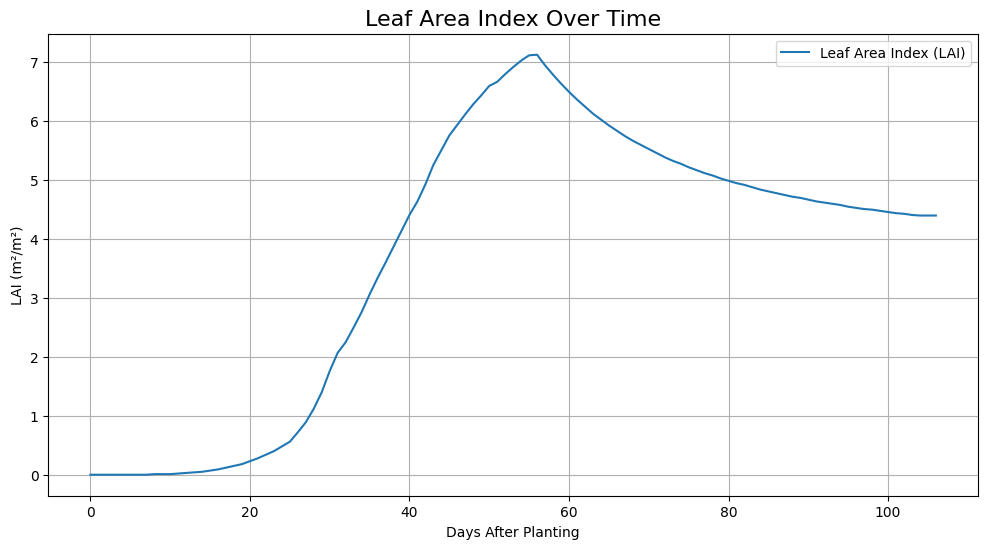

In [2]:
# Daily RL State Vector Display
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- 1. SIMULATION SETUP ---

# --- DEFINE FILE PATHS AND DATES ---
WEATHER_FILE_PATH = r"D:\Final-Year-Project\env_trails\weather\CHEN1301.WTH" 
SOIL_FILE_PATH = r"D:\Final-Year-Project\env_trails\MY_GENERATED_SOIL.SOL"
SOIL_ID = "SG12387893"
PLANTING_DATE = datetime(2013, 6, 15)

# --- Load DSSAT Objects ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

# --- Configure Management ---
field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]
initial_values_table = [(depth, 0.35, 1.5, 1.5) for depth in soil_depths]
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

irrigation_events = [filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=day), irop='IR001', irval=5) for day in range(90)]
irrigation = filex.Irrigation(table=irrigation_events)

simulation_controls = filex.SimulationControls(
    general=filex.SCGeneral(sdate=PLANTING_DATE),
    options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
    methods=filex.SCMethods(infil='S'),
    management=filex.SCManagement(irrig='A', ferti='N', resid='N', harvs='M'),
    outputs=filex.SCOutputs(
        grout='Y',  # Growth output (PlantGro.OUT)
        waout='Y',  # Water output (SoilWat.OUT)
        niout='Y'   # Nitrogen output (SoilNi.OUT)
    )
)
print("✅ Management files configured.")

# --- 2. RUN SIMULATION ---
dssat_output = None
try:
    workspace = os.path.join("dummy", "dssat_state_run")
    os.makedirs(workspace, exist_ok=True)
    
    shutil.copy(WEATHER_FILE_PATH, workspace)
    shutil.copy(SOIL_FILE_PATH, workspace)
    
    dssat = DSSAT(workspace)
    print(f"🚀 Running simulation in: {workspace}")
    
    results = dssat.run_treatment(
        field=field, cultivar=cultivar, planting=planting,
        initial_conditions=initial_conditions, irrigation=irrigation,
        simulation_controls=simulation_controls
    )
    print("\n--- SIMULATION COMPLETE ---")
    dssat_output = dssat.output_tables

except Exception as e:
    print(f"❌ An error occurred during the DSSAT run: {e}")


# --- 3. CONSTRUCT THE DAILY STATE VECTOR DATAFRAME ---

if dssat_output and 'SoilWat' in dssat_output:
    print("\n--- Constructing Daily RL State Vector ---")
    
    # Base DataFrames
    plantgro = dssat_output['PlantGro'].set_index('DAP')
    
    soilwat_full = dssat_output['SoilWat']
    soilwat_full['DAP'] = soilwat_full['DAS'] - 1 
    soilwat_full = soilwat_full.set_index('DAP')

    weather_df_full = pd.DataFrame(weather_station.table).copy()
    weather_df_full['date'] = pd.to_datetime(weather_df_full['date'])
    weather_df_full['DAP'] = (weather_df_full['date'] - PLANTING_DATE).dt.days
    weather_df_full = weather_df_full.set_index('DAP')
    
    # --- THE FIX IS HERE (PART 1) ---
    # Select the cumulative irrigation column 'IRRC'
    soilwat_cols_to_join = [col for col in soilwat_full.columns if col.startswith('SW') or col in ['SWXD', 'ETD', 'IRRC']]
    # --- END OF FIX ---

    weather_cols_to_join = ['srad', 'tmax', 'tmin', 'rain']
    
    soilwat_selected = soilwat_full[soilwat_cols_to_join]
    weather_selected = weather_df_full[weather_cols_to_join]
    
    combined_df = plantgro.join(soilwat_selected, how='inner').join(weather_selected, how='left')
    
    # --- THE FIX IS HERE (PART 2) ---
    # Calculate the daily irrigation amount from the cumulative 'IRRC' column
    combined_df['daily_irr'] = combined_df['IRRC'].diff().fillna(0)
    # --- END OF FIX ---

    soil_layers = soil_profile.table
    layer_depths = np.array([float(layer['slb']) for layer in soil_layers])

    state_records = []
    irrigation_days = []

    for dap in range(len(combined_df)):
        current_day_data = combined_df.iloc[dap]
        history = combined_df.iloc[max(0, dap-7):dap+1]
        
        def get_sw_by_depth(min_depth, max_depth):
            sw_cols = [f'SW{i+1}D' for i, depth in enumerate(layer_depths) if min_depth < depth <= max_depth]
            return current_day_data[sw_cols].mean() if sw_cols else np.nan

        # --- THE FIX IS HERE (PART 3) ---
        # Update all irrigation history logic to use the new 'daily_irr' column
        irr_history = combined_df['daily_irr'].iloc[:dap+1]
        
        last_irrigation_amount = irr_history.iloc[-1]
        if last_irrigation_amount > 0:
            irrigation_days.append(dap)

        days_since_last_irrigation = dap - irrigation_days[-1] if irrigation_days else dap
        
        irr_t_minus_1 = irr_history.iloc[-2] if len(irr_history) > 1 else 0
        irr_t_minus_2 = irr_history.iloc[-3] if len(irr_history) > 2 else 0
        irr_t_minus_3 = irr_history.iloc[-4] if len(irr_history) > 3 else 0
        irr_t_minus_4 = irr_history.iloc[-5] if len(irr_history) > 4 else 0
        
        cumulative_irrigation = irr_history.sum()
        
        irrigation_intervals = np.diff(irrigation_days)
        irrigation_interval_avg = np.mean(irrigation_intervals) if len(irrigation_intervals) > 0 else 0
        # --- END OF FIX ---

        state = {
            # Crop Variables
            'days_after_planting': dap,
            'phenological_stage': current_day_data.get('GSTD', 0),
            'leaf_area_index': current_day_data.get('LAID', 0),
            'total_biomass': current_day_data.get('CWAD', 0),
            'cumulative_gdd': 0, 

            # Soil Variables
            'soil_water_content_0_30cm': get_sw_by_depth(0, 30),
            'soil_water_content_30_60cm': get_sw_by_depth(30, 60),
            'soil_water_content_60_100cm': get_sw_by_depth(60, 100),
            'available_water_fraction': current_day_data.get('SWXD', 0),
            'water_stress_factor': current_day_data.get('WSGD', 0),
            'days_since_last_rain': (history['rain'] == 0)[::-1].cumprod().sum() if dap > 0 else 0,
            
            # Weather Variables
            'rainfall_1day': history['rain'].iloc[-1:].sum(),
            'rainfall_3day': history['rain'].iloc[-3:].sum(),
            'rainfall_7day': history['rain'].iloc[-7:].sum(),
            'temperature_min': current_day_data.get('tmin', 0),
            'temperature_max': current_day_data.get('tmax', 0),
            'temperature_avg': (current_day_data.get('tmax', 0) + current_day_data.get('tmin', 0)) / 2,
            'solar_radiation': current_day_data.get('srad', 0),
            'reference_et': current_day_data.get('ETD', 0),
            'forecast_rain_mm': 0,
            
            # Irrigation History
            'last_irrigation_amount': last_irrigation_amount,
            'irrigation_amount_t1': irr_t_minus_1,
            'irrigation_amount_t2': irr_t_minus_2,
            'irrigation_amount_t3': irr_t_minus_3,
            'irrigation_amount_t4': irr_t_minus_4,
            'days_since_last_irrigation': days_since_last_irrigation,
            'cumulative_irrigation': cumulative_irrigation,
            'irrigation_interval_avg': irrigation_interval_avg,
        }
        
        state_records.append(state)

    state_df = pd.DataFrame(state_records)
    state_df = state_df.fillna(0)
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    
    print("\n--- Complete Daily State Vector (Planting to Harvest) ---")
    print(state_df.round(2))

    plt.figure(figsize=(12, 6))
    plt.plot(state_df['days_after_planting'], state_df['leaf_area_index'], label='Leaf Area Index (LAI)')
    plt.title('Leaf Area Index Over Time', fontsize=16)
    plt.xlabel('Days After Planting')
    plt.ylabel('LAI (m²/m²)')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print("\nSimulation output is missing or incomplete. Could not construct state vector.")



In [ ]:
# Daily RL State Vector Display
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- 1. SIMULATION SETUP ---

# --- DEFINE FILE PATHS AND DATES ---
WEATHER_FILE_PATH = r"D:\Final-Year-Project\project-trail\defaults\Weather\ALCL5601.WTH" 
SOIL_FILE_PATH = "MY_GENERATED_SOIL.SOL"
SOIL_ID = "SG12387893"
PLANTING_DATE = datetime(1956, 6, 15)

# --- Load DSSAT Objects ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

# --- Configure Management ---
field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]
initial_values_table = [(depth, 0.35, 1.5, 1.5) for depth in soil_depths]
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

irrigation_events = [filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=day), irop='IR001', irval=5) for day in range(90)]
irrigation = filex.Irrigation(table=irrigation_events)

simulation_controls = filex.SimulationControls(
    general=filex.SCGeneral(sdate=PLANTING_DATE),
    options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
    methods=filex.SCMethods(infil='S'),
    management=filex.SCManagement(irrig='A', ferti='N', resid='N', harvs='M'),
    outputs=filex.SCOutputs(
        grout='Y',  # Growth output (PlantGro.OUT)
        waout='Y',  # Water output (SoilWat.OUT)
        niout='Y'   # Nitrogen output (SoilNi.OUT)
    )
)
print("✅ Management files configured.")

# --- 2. RUN SIMULATION ---
dssat_output = None
try:
    workspace = os.path.join("dummy", "dssat_state_run")
    os.makedirs(workspace, exist_ok=True)
    
    shutil.copy(WEATHER_FILE_PATH, workspace)
    shutil.copy(SOIL_FILE_PATH, workspace)
    
    dssat = DSSAT(workspace)
    print(f"🚀 Running simulation in: {workspace}")
    
    results = dssat.run_treatment(
        field=field, cultivar=cultivar, planting=planting,
        initial_conditions=initial_conditions, irrigation=irrigation,
        simulation_controls=simulation_controls
    )
    print("\n--- SIMULATION COMPLETE ---")
    dssat_output = dssat.output_tables

except Exception as e:
    print(f"❌ An error occurred during the DSSAT run: {e}")


# --- 3. CONSTRUCT THE DAILY STATE VECTOR DATAFRAME ---

if dssat_output and 'SoilWat' in dssat_output:
    print("\n--- Constructing Daily RL State Vector ---")
    
    # Base DataFrames
    plantgro = dssat_output['PlantGro'].set_index('DAP')
    
    soilwat_full = dssat_output['SoilWat']
    soilwat_full['DAP'] = soilwat_full['DAS'] - 1 
    soilwat_full = soilwat_full.set_index('DAP')

    weather_df_full = pd.DataFrame(weather_station.table).copy()
    
    # --- THE FIX IS HERE ---
    # Standardize column names to lowercase to prevent KeyErrors
    weather_df_full.columns = weather_df_full.columns.str.lower()
    # --- END OF FIX ---
    
    weather_df_full['date'] = pd.to_datetime(weather_df_full['date'])
    weather_df_full['DAP'] = (weather_df_full['date'] - PLANTING_DATE).dt.days
    weather_df_full = weather_df_full.set_index('DAP')
    
    soilwat_cols_to_join = [col for col in soilwat_full.columns if col.startswith('SW') or col in ['SWXD', 'ETD', 'IRRC']]
    weather_cols_to_join = ['srad', 'tmax', 'tmin', 'rain']
    
    soilwat_selected = soilwat_full[soilwat_cols_to_join]
    weather_selected = weather_df_full[weather_cols_to_join]
    
    combined_df = plantgro.join(soilwat_selected, how='inner').join(weather_selected, how='left')
    
    combined_df['daily_irr'] = combined_df['IRRC'].diff().fillna(0)

    soil_layers = soil_profile.table
    layer_depths = np.array([float(layer['slb']) for layer in soil_layers])

    state_records = []
    irrigation_days = []

    for dap in range(len(combined_df)):
        current_day_data = combined_df.iloc[dap]
        history = combined_df.iloc[max(0, dap-7):dap+1]
        
        def get_sw_by_depth(min_depth, max_depth):
            sw_cols = [f'SW{i+1}D' for i, depth in enumerate(layer_depths) if min_depth < depth <= max_depth]
            return current_day_data[sw_cols].mean() if sw_cols else np.nan

        irr_history = combined_df['daily_irr'].iloc[:dap+1]
        
        last_irrigation_amount = irr_history.iloc[-1]
        if last_irrigation_amount > 0:
            irrigation_days.append(dap)

        days_since_last_irrigation = dap - irrigation_days[-1] if irrigation_days else dap
        
        irr_t_minus_1 = irr_history.iloc[-2] if len(irr_history) > 1 else 0
        irr_t_minus_2 = irr_history.iloc[-3] if len(irr_history) > 2 else 0
        irr_t_minus_3 = irr_history.iloc[-4] if len(irr_history) > 3 else 0
        irr_t_minus_4 = irr_history.iloc[-5] if len(irr_history) > 4 else 0
        
        cumulative_irrigation = irr_history.sum()
        
        irrigation_intervals = np.diff(irrigation_days)
        irrigation_interval_avg = np.mean(irrigation_intervals) if len(irrigation_intervals) > 0 else 0

        state = {
            # Crop Variables
            'days_after_planting': dap,
            'phenological_stage': current_day_data.get('GSTD', 0),
            'leaf_area_index': current_day_data.get('LAID', 0),
            'total_biomass': current_day_data.get('CWAD', 0),
            'cumulative_gdd': 0, 

            # Soil Variables
            'soil_water_content_0_30cm': get_sw_by_depth(0, 30),
            'soil_water_content_30_60cm': get_sw_by_depth(30, 60),
            'soil_water_content_60_100cm': get_sw_by_depth(60, 100),
            'available_water_fraction': current_day_data.get('SWXD', 0),
            'water_stress_factor': current_day_data.get('WSGD', 0),
            'days_since_last_rain': (history['rain'] == 0)[::-1].cumprod().sum() if dap > 0 else 0,
            
            # Weather Variables
            'rainfall_1day': history['rain'].iloc[-1:].sum(),
            'rainfall_3day': history['rain'].iloc[-3:].sum(),
            'rainfall_7day': history['rain'].iloc[-7:].sum(),
            'temperature_min': current_day_data.get('tmin', 0),
            'temperature_max': current_day_data.get('tmax', 0),
            'temperature_avg': (current_day_data.get('tmax', 0) + current_day_data.get('tmin', 0)) / 2,
            'solar_radiation': current_day_data.get('srad', 0),
            'reference_et': current_day_data.get('ETD', 0),
            'forecast_rain_mm': 0,
            
            # Irrigation History
            'last_irrigation_amount': last_irrigation_amount,
            'irrigation_amount_t1': irr_t_minus_1,
            'irrigation_amount_t2': irr_t_minus_2,
            'irrigation_amount_t3': irr_t_minus_3,
            'irrigation_amount_t4': irr_t_minus_4,
            'days_since_last_irrigation': days_since_last_irrigation,
            'cumulative_irrigation': cumulative_irrigation,
            'irrigation_interval_avg': irrigation_interval_avg,
        }
        
        state_records.append(state)

    state_df = pd.DataFrame(state_records)
    state_df = state_df.fillna(0)
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    
    print("\n--- Complete Daily State Vector (Planting to Harvest) ---")
    print(state_df.round(2))

    plt.figure(figsize=(12, 6))
    plt.plot(state_df['days_after_planting'], state_df['leaf_area_index'], label='Leaf Area Index (LAI)')
    plt.title('Leaf Area Index Over Time', fontsize=16)
    plt.xlabel('Days After Planting')
    plt.ylabel('LAI (m²/m²)')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print("\nSimulation output is missing or incomplete. Could not construct state vector.")



In [ ]:
# Daily RL State Vector Display
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- 1. SIMULATION SETUP ---

# --- DEFINE FILE PATHS AND DATES ---
WEATHER_FILE_PATH = r"D:\Final-Year-Project\project-trail\defaults\Weather\ALCL5601.WTH" 
SOIL_FILE_PATH = "MY_GENERATED_SOIL.SOL"
SOIL_ID = "SG12387893"
PLANTING_DATE = datetime(1956, 6, 15)

# --- Load DSSAT Objects ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

# --- Configure Management ---
field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]
initial_values_table = [(depth, 0.35, 1.5, 1.5) for depth in soil_depths]
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

irrigation_events = [filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=day), irop='IR001', irval=5) for day in range(90)]
irrigation = filex.Irrigation(table=irrigation_events)

simulation_controls = filex.SimulationControls(
    general=filex.SCGeneral(sdate=PLANTING_DATE),
    options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
    methods=filex.SCMethods(infil='S'),
    management=filex.SCManagement(irrig='A', ferti='N', resid='N', harvs='M'),
    outputs=filex.SCOutputs(
        grout='Y',  # Growth output (PlantGro.OUT)
        waout='Y',  # Water output (SoilWat.OUT)
        niout='Y'   # Nitrogen output (SoilNi.OUT)
    )
)
print("✅ Management files configured.")

# --- 2. RUN SIMULATION ---
dssat_output = None
try:
    workspace = os.path.join("dummy", "dssat_state_run")
    os.makedirs(workspace, exist_ok=True)
    
    shutil.copy(WEATHER_FILE_PATH, workspace)
    shutil.copy(SOIL_FILE_PATH, workspace)
    
    dssat = DSSAT(workspace)
    print(f"🚀 Running simulation in: {workspace}")
    
    results = dssat.run_treatment(
        field=field, cultivar=cultivar, planting=planting,
        initial_conditions=initial_conditions, irrigation=irrigation,
        simulation_controls=simulation_controls
    )
    print("\n--- SIMULATION COMPLETE ---")
    dssat_output = dssat.output_tables

except Exception as e:
    print(f"❌ An error occurred during the DSSAT run: {e}")


# --- 3. CONSTRUCT THE DAILY STATE VECTOR DATAFRAME ---

if dssat_output and 'SoilWat' in dssat_output:
    print("\n--- Constructing Daily RL State Vector ---")
    
    # Base DataFrames
    plantgro = dssat_output['PlantGro'].set_index('DAP')
    
    soilwat_full = dssat_output['SoilWat']
    soilwat_full['DAP'] = soilwat_full['DAS'] - 1 
    soilwat_full = soilwat_full.set_index('DAP')

    weather_df_full = pd.DataFrame(weather_station.table).copy()
    weather_df_full.columns = weather_df_full.columns.str.lower()
    weather_df_full['date'] = pd.to_datetime(weather_df_full['date'])
    weather_df_full['DAP'] = (weather_df_full['date'] - PLANTING_DATE).dt.days
    weather_df_full = weather_df_full.set_index('DAP')
    
    # Select only the specific columns needed from each dataframe to avoid overlap.
    soilwat_cols_to_join = [col for col in soilwat_full.columns if col.startswith('SW') or col in ['SWXD', 'ETD', 'IRRC']]
    weather_cols_to_join = ['srad', 'tmax', 'tmin', 'rain']
    
    soilwat_selected = soilwat_full[soilwat_cols_to_join]
    weather_selected = weather_df_full[weather_cols_to_join]
    
    combined_df = plantgro.join(soilwat_selected, how='inner').join(weather_selected, how='left')
    
    # --- THE FIX IS HERE (PART 1) ---
    # Calculate the daily irrigation amount from the cumulative 'IRRC' column
    combined_df['daily_irr'] = combined_df['IRRC'].diff().fillna(combined_df['IRRC'])
    # --- END OF FIX ---

    soil_layers = soil_profile.table
    layer_depths = np.array([float(layer['slb']) for layer in soil_layers])

    state_records = []
    irrigation_days = []

    for dap in range(len(combined_df)):
        current_day_data = combined_df.iloc[dap]
        history = combined_df.iloc[max(0, dap-7):dap+1]
        
        def get_sw_by_depth(min_depth, max_depth):
            sw_cols = [f'SW{i+1}D' for i, depth in enumerate(layer_depths) if min_depth < depth <= max_depth]
            return current_day_data[sw_cols].mean() if sw_cols else np.nan

        # --- THE FIX IS HERE (PART 2) ---
        # Update all irrigation history logic to use the new 'daily_irr' column
        irr_history = combined_df['daily_irr'].iloc[:dap+1]
        
        last_irrigation_amount = irr_history.iloc[-1]
        if last_irrigation_amount > 0:
            irrigation_days.append(dap)

        days_since_last_irrigation = dap - irrigation_days[-1] if irrigation_days else dap + 1
        
        irr_t_minus_1 = irr_history.iloc[-2] if len(irr_history) > 1 else 0
        irr_t_minus_2 = irr_history.iloc[-3] if len(irr_history) > 2 else 0
        irr_t_minus_3 = irr_history.iloc[-4] if len(irr_history) > 3 else 0
        irr_t_minus_4 = irr_history.iloc[-5] if len(irr_history) > 4 else 0
        
        cumulative_irrigation = current_day_data.get('IRRC', 0)
        
        irrigation_intervals = np.diff(irrigation_days)
        irrigation_interval_avg = np.mean(irrigation_intervals) if len(irrigation_intervals) > 0 else 0
        # --- END OF FIX ---

        state = {
            # Crop Variables
            'days_after_planting': dap,
            'phenological_stage': current_day_data.get('GSTD', 0),
            'leaf_area_index': current_day_data.get('LAID', 0),
            'total_biomass': current_day_data.get('CWAD', 0),
            'cumulative_gdd': 0, 

            # Soil Variables
            'soil_water_content_0_30cm': get_sw_by_depth(0, 30),
            'soil_water_content_30_60cm': get_sw_by_depth(30, 60),
            'soil_water_content_60_100cm': get_sw_by_depth(60, 100),
            'available_water_fraction': current_day_data.get('SWXD', 0),
            'water_stress_factor': current_day_data.get('WSGD', 0),
            'days_since_last_rain': (history['rain'] == 0)[::-1].cumprod().sum() if dap > 0 else 0,
            
            # Weather Variables
            'rainfall_1day': history['rain'].iloc[-1:].sum(),
            'rainfall_3day': history['rain'].iloc[-3:].sum(),
            'rainfall_7day': history['rain'].iloc[-7:].sum(),
            'temperature_min': current_day_data.get('tmin', 0),
            'temperature_max': current_day_data.get('tmax', 0),
            'temperature_avg': (current_day_data.get('tmax', 0) + current_day_data.get('tmin', 0)) / 2,
            'solar_radiation': current_day_data.get('srad', 0),
            'reference_et': current_day_data.get('ETD', 0),
            'forecast_rain_mm': 0,
            
            # Irrigation History
            'last_irrigation_amount': last_irrigation_amount,
            'irrigation_amount_t1': irr_t_minus_1,
            'irrigation_amount_t2': irr_t_minus_2,
            'irrigation_amount_t3': irr_t_minus_3,
            'irrigation_amount_t4': irr_t_minus_4,
            'days_since_last_irrigation': days_since_last_irrigation,
            'cumulative_irrigation': cumulative_irrigation,
            'irrigation_interval_avg': irrigation_interval_avg,
        }
        
        state_records.append(state)

    state_df = pd.DataFrame(state_records)
    state_df = state_df.fillna(0)
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    
    print("\n--- Complete Daily State Vector (Planting to Harvest) ---")
    print(state_df.round(2))

    plt.figure(figsize=(12, 6))
    plt.plot(state_df['days_after_planting'], state_df['leaf_area_index'], label='Leaf Area Index (LAI)')
    plt.title('Leaf Area Index Over Time', fontsize=16)
    plt.xlabel('Days After Planting')
    plt.ylabel('LAI (m²/m²)')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print("\nSimulation output is missing or incomplete. Could not construct state vector.")



In [3]:
# Daily RL State Vector Display
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- 1. SIMULATION SETUP ---

# --- DEFINE FILE PATHS AND DATES ---
WEATHER_FILE_PATH = r"D:\Final-Year-Project\env_trails\weather\CHEN1301.WTH" 
SOIL_FILE_PATH = r"D:\Final-Year-Project\env_trails\MY_GENERATED_SOIL.SOL"
SOIL_ID = "SG12387893"
PLANTING_DATE = datetime(2013, 6, 15)

# --- Load DSSAT Objects ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

# --- Configure Management ---
field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]
initial_values_table = [(depth, 0.35, 1.5, 1.5) for depth in soil_depths]
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

irrigation_events = [filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=day), irop='IR001', irval=5) for day in range(90)]
irrigation = filex.Irrigation(table=irrigation_events)

simulation_controls = filex.SimulationControls(
    general=filex.SCGeneral(sdate=PLANTING_DATE),
    options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
    methods=filex.SCMethods(infil='S'),
    management=filex.SCManagement(irrig='A', ferti='N', resid='N', harvs='M'),
    outputs=filex.SCOutputs(
        grout='Y',  # Growth output (PlantGro.OUT)
        waout='Y',  # Water output (SoilWat.OUT)
        niout='Y'   # Nitrogen output (SoilNi.OUT)
    )
)
print("✅ Management files configured.")

# --- 2. RUN SIMULATION ---
dssat_output = None
try:
    workspace = os.path.join("dummy", "dssat_state_run")
    os.makedirs(workspace, exist_ok=True)
    
    shutil.copy(WEATHER_FILE_PATH, workspace)
    shutil.copy(SOIL_FILE_PATH, workspace)
    
    dssat = DSSAT(workspace)
    print(f"🚀 Running simulation in: {workspace}")
    
    results = dssat.run_treatment(
        field=field, cultivar=cultivar, planting=planting,
        initial_conditions=initial_conditions, irrigation=irrigation,
        simulation_controls=simulation_controls
    )
    print("\n--- SIMULATION COMPLETE ---")
    dssat_output = dssat.output_tables

except Exception as e:
    print(f"❌ An error occurred during the DSSAT run: {e}")


# --- 3. CONSTRUCT THE DAILY STATE VECTOR DATAFRAME -

✅ Management files configured.
dummy\dssat_state_run created.
🚀 Running simulation in: dummy\dssat_state_run

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1  65 106 16357  7506   501    31   417   268     0   -99      0  186

--- SIMULATION COMPLETE ---


In [4]:
dssat_output['Weather']

@YEAR  DOY  DAS  PRED  DAYLD  TWLD  SRAD  PARD  CLDD  TMXD  TMND  \
2013-06-15  2013  166    1   1.0   12.7  13.6  16.5  18.3  0.45  33.1  23.6   
2013-06-16  2013  167    2   0.0   12.7  13.6  17.3  18.3  0.42  34.4  22.9   
2013-06-17  2013  168    3   0.2   12.7  13.6  16.4  18.3  0.45  33.1  23.5   
2013-06-18  2013  169    4   4.1   12.7  13.6  17.6  18.3  0.41  33.7  22.8   
2013-06-19  2013  170    5   4.0   12.7  13.6  16.4  18.3  0.45  34.4  22.9   
2013-06-20  2013  171    6   1.8   12.7  13.6  20.9  18.3  0.30  34.1  22.3   
2013-06-21  2013  172    7   3.5   12.7  13.6  19.0  18.3  0.37  34.1  22.4   
2013-06-22  2013  173    8   1.2   12.7  13.6  18.8  18.3  0.37  30.7  22.5   
2013-06-23  2013  174    9   0.2   12.7  13.6  18.9  18.3  0.37  33.1  22.2   
2013-06-24  2013  175   10   1.2   12.7  13.6  15.2  18.3  0.49  32.4  23.0   
2013-06-25  2013  176   11   0.5   12.7  13.6  15.7  18.3  0.48  35.2  22.6   
2013-06-26  2013  177   12  15.2   12.7  13.6  16.5  18.3  0.45  33.9  22.6   
2013-06-27  2013  178   13   3.4   12.7  13.6  20.7  18.3  0.31  31.5  22.9   
2013-06-28  2013  179   14  11.0   12.7  13.6  19.3  18.3  0.36  32.4  22.0   
2013-06-29  2013  180   15   2.2   12.7  13.6  19.4  18.3  0.35  33.2  21.6   
2013-06-30  2013  181   16   0.4   12.7  13.6  22.9  18.3  0.24  31.4  21.5   
2013-07-01  2013  182   17   0.1   12.7  13.6  22.6  16.0  0.25  31.6  21.5   
2013-07-02  2013  183   18   1.4   12.7  13.6  18.2  16.0  0.39  32.6  21.2   
2013-07-03  2013  184   19   1.1   12.7  13.6  17.1  16.0  0.43  30.4  21.3   
2013-07-04  2013  185   20   1.6   12.7  13.6  17.7  16.0  0.41  34.3  22.2   
2013-07-05  2013  186   21   0.0   12.7  13.6  13.2  16.0  0.56  33.3  22.9   
2013-07-06  2013  187   22   6.3   12.7  13.6  19.9  16.0  0.34  33.7  23.1   
2013-07-07  2013  188   23   2.6   12.7  13.6  14.7  16.0  0.51  29.9  22.4   
2013-07-08  2013  189   24   0.3   12.7  13.6  14.8  16.0  0.51  32.5  22.1   
2013-07-09  2013  190   25   3.3   12.7  13.6  15.4  16.0  0.49  32.6  22.4   
2013-07-10  2013  191   26  13.4   12.7  13.6  16.7  16.0  0.44  31.9  22.0   
2013-07-11  2013  192   27   2.7   12.7  13.6  15.3  16.0  0.49  32.9  20.9   
2013-07-12  2013  193   28   0.0   12.7  13.6  14.4  16.0  0.52  31.1  21.5   
2013-07-13  2013  194   29   1.4   12.7  13.6  16.2  16.0  0.46  32.5  21.5   
2013-07-14  2013  195   30   0.7   12.7  13.6  16.7  16.0  0.44  31.9  22.5   
2013-07-15  2013  196   31   1.6   12.7  13.6  18.2  16.0  0.39  33.1  22.6   
2013-07-16  2013  197   32   5.2   12.7  13.6  14.3  16.0  0.52  29.8  23.0   
2013-07-17  2013  198   33   0.0   12.7  13.5  10.9  16.0  0.64  31.1  22.2   
2013-07-18  2013  199   34   2.2   12.6  13.5  15.3  16.0  0.49  32.4  22.7   
2013-07-19  2013  200   35  14.3   12.6  13.5  14.8  16.0  0.51  29.4  22.3   
2013-07-20  2013  201   36   9.4   12.6  13.5  16.7  16.0  0.44  32.0  21.8   
2013-07-21  2013  202   37   1.4   12.6  13.5  15.3  16.0  0.49  30.9  21.4   
2013-07-22  2013  203   38   2.6   12.6  13.5  13.7  16.0  0.54  30.7  21.6   
2013-07-23  2013  204   39   0.6   12.6  13.5  14.8  16.0  0.51  32.3  22.0   
2013-07-24  2013  205   40   1.0   12.6  13.5  14.4  16.0  0.52  32.0  21.6   
2013-07-25  2013  206   41   0.1   12.6  13.5  14.5  16.0  0.52  33.2  22.1   
2013-07-26  2013  207   42   0.1   12.6  13.5  13.2  16.0  0.56  32.1  21.9   
2013-07-27  2013  208   43   0.3   12.6  13.5  16.6  16.0  0.45  33.8  21.9   
2013-07-28  2013  209   44   1.5   12.6  13.5  20.2  16.0  0.33  33.1  21.9   
2013-07-29  2013  210   45   0.1   12.6  13.5  16.6  16.0  0.45  30.9  21.8   
2013-07-30  2013  211   46   0.0   12.6  13.4  17.8  16.0  0.41  33.3  21.4   
2013-07-31  2013  212   47   0.1   12.6  13.4  15.1  16.0  0.50  32.7  22.6   
2013-08-01  2013  213   48   1.1   12.5  13.4  16.3  18.1  0.46  33.1  22.4   
2013-08-02  2013  214   49   0.1   12.5  13.4  16.8  18.1  0.44  33.9  21.9   
2013-08-03  2013  215   50   4.5   12.5  13.4  16.7  18.1  0.

In [5]:

if dssat_output and 'SoilWat' in dssat_output:
    print("\n--- Constructing Daily RL State Vector ---")
    
    # Base DataFrames
    plantgro = dssat_output['PlantGro']
    
    soilwat_full = dssat_output['SoilWat']
    soilwat_full['DAP'] = soilwat_full['DAS'] - 1 

    weather_df_full = pd.DataFrame(weather_station.table)
    pdss = weather_df_full[['date', 'srad', 'tmax', 'tmin','rain']]
    print(pdss)
    # --- THE FIX IS HERE (PART 1) ---
    # Standardize column names to lowercase to prevent KeyErrors
    weather_df_full.columns = weather_df_full.columns.str.lower()
    # --- END OF FIX ---
    
    # weather_df_full['date'] = pd.to_datetime(weather_df_full['date'])
    weather_df_full['DAP'] = (weather_df_full['date'] - PLANTING_DATE).dt.days
    
    # --- THE FIX IS HERE (PART 2) ---
    # Use a more robust 'merge' on the 'DAP' column instead of 'join' on the index
    weather_cols_to_join = ['DAP', 'srad', 'tmax', 'tmin', 'rain']
    
    # Merge PlantGro and SoilWat first
    combined_dfa = pd.merge(plantgro, soilwat_full, on='DAP', how='inner')
    # Then merge the result with the weather data
    combined_dfb = pd.merge(combined_dfa, weather_df_full[weather_cols_to_join], on='DAP', how='left')
    # --- END OF FIX ---
    
    combined_df['daily_irr'] = combined_dfb['IRRC'].diff().fillna(combined_df['IRRC'])

    soil_layers = soil_profile.table
    layer_depths = np.array([float(layer['slb']) for layer in soil_layers])

    state_records = []
    irrigation_days = []

    for dap in range(len(combined_df)):
        current_day_data = combined_df.iloc[dap]
        history = combined_df.iloc[max(0, dap-7):dap+1]
        
        def get_sw_by_depth(min_depth, max_depth):
            sw_cols = [f'SW{i+1}D' for i, depth in enumerate(layer_depths) if min_depth < depth <= max_depth]
            return current_day_data[sw_cols].mean() if sw_cols else np.nan

        irr_history = combined_df['daily_irr'].iloc[:dap+1]
        
        last_irrigation_amount = irr_history.iloc[-1]
        if last_irrigation_amount > 0:
            irrigation_days.append(dap)

        days_since_last_irrigation = dap - irrigation_days[-1] if irrigation_days else dap + 1
        
        irr_t_minus_1 = irr_history.iloc[-2] if len(irr_history) > 1 else 0
        irr_t_minus_2 = irr_history.iloc[-3] if len(irr_history) > 2 else 0
        irr_t_minus_3 = irr_history.iloc[-4] if len(irr_history) > 3 else 0
        irr_t_minus_4 = irr_history.iloc[-5] if len(irr_history) > 4 else 0
        
        cumulative_irrigation = current_day_data.get('IRRC', 0)
        
        irrigation_intervals = np.diff(irrigation_days)
        irrigation_interval_avg = np.mean(irrigation_intervals) if len(irrigation_intervals) > 0 else 0

        state = {
            'days_after_planting': dap,
            'phenological_stage': current_day_data.get('GSTD', 0),
            'leaf_area_index': current_day_data.get('LAID', 0),
            'total_biomass': current_day_data.get('CWAD', 0),
            'cumulative_gdd': 0, 
            'soil_water_content_0_30cm': get_sw_by_depth(0, 30),
            'soil_water_content_30_60cm': get_sw_by_depth(30, 60),
            'soil_water_content_60_100cm': get_sw_by_depth(60, 100),
            'available_water_fraction': current_day_data.get('SWXD', 0),
            'water_stress_factor': current_day_data.get('WSGD', 0),
            'days_since_last_rain': (history['rain'] == 0)[::-1].cumprod().sum() if dap > 0 else 0,
            'rainfall_1day': history['rain'].iloc[-1:].sum(),
            'rainfall_3day': history['rain'].iloc[-3:].sum(),
            'rainfall_7day': history['rain'].iloc[-7:].sum(),
            'temperature_min': current_day_data.get('tmin', 0),
            'temperature_max': current_day_data.get('tmax', 0),
            'temperature_avg': (current_day_data.get('tmax', 0) + current_day_data.get('tmin', 0)) / 2,
            'solar_radiation': current_day_data.get('srad', 0),
            'reference_et': current_day_data.get('ETD', 0),
            'forecast_rain_mm': 0,
            'last_irrigation_amount': last_irrigation_amount,
            'irrigation_amount_t1': irr_t_minus_1,
            'irrigation_amount_t2': irr_t_minus_2,
            'irrigation_amount_t3': irr_t_minus_3,
            'irrigation_amount_t4': irr_t_minus_4,
            'days_since_last_irrigation': days_since_last_irrigation,
            'cumulative_irrigation': cumulative_irrigation,
            'irrigation_interval_avg': irrigation_interval_avg,
        }
        
        state_records.append(state)

    state_df = pd.DataFrame(state_records)
    state_df = state_df.fillna(0)
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    
    print("\n--- Complete Daily State Vector (Planting to Harvest) ---")
    print(state_df.round(2))

    plt.figure(figsize=(12, 6))
    plt.plot(state_df['days_after_planting'], state_df['leaf_area_index'], label='Leaf Area Index (LAI)')
    plt.title('Leaf Area Index Over Time', fontsize=16)
    plt.xlabel('Days After Planting')
    plt.ylabel('LAI (m²/m²)')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print("\nSimulation output is missing or incomplete. Could not construct state vector.")


--- Constructing Daily RL State Vector ---
           date  srad  tmax  tmin  rain
0    2013-01-01  19.7  31.8  18.8   0.0
1    2013-01-02  19.7  32.1  16.9   0.0
2    2013-01-03  19.8  33.1  16.6   0.0
3    2013-01-04  19.9  33.0  20.1   0.0
4    2013-01-05  19.0  33.3  19.9   0.0
5    2013-01-06  18.1  32.0  20.8   0.0
6    2013-01-07  18.7  32.2  19.0   0.0
7    2013-01-08  19.6  33.7  18.1   0.0
8    2013-01-09  19.9  31.8  18.8   0.0
9    2013-01-10  20.5  32.1  17.9   0.0
10   2013-01-11  20.2  31.5  16.6   0.0
11   2013-01-12  20.1  31.2  16.5   0.0
12   2013-01-13  20.1  31.7  15.6   0.0
13   2013-01-14  20.0  31.9  14.9   0.0
14   2013-01-15  21.1  31.8  16.2   0.0
15   2013-01-16  20.2  30.8  17.2   0.0
16   2013-01-17  18.7  30.5  17.1   0.0
17   2013-01-18  20.9  31.0  15.8   0.0
18   2013-01-19  20.7  31.5  16.5   0.0
19   2013-01-20  22.6  31.9  15.1   0.0
20   2013-01-21  20.2  32.3  18.1   0.0
21   2013-01-22  21.9  31.7  15.9   0.0
22   2013-01-23  21.1  31.6  16.2   

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Timestamp'

In [ ]:
# DSSAT Parameter and Abbreviation Glossary

This document provides a comprehensive list of the abbreviations and parameters used in your DSSAT-Python scripts, their full names, and what they represent.

## 1. Time and Date Parameters

| Abbreviation | Full Name | Description |
|--------------|-----------|-------------|
| **DAS** | Days After Start | The number of days since the simulation began (sdate). Starts from 1. |
| **DAP** | Days After Planting | The number of days since the crop was planted (pdate). Starts from 0. |
| **DOY** | Day of Year | The Julian day of the year (e.g., January 1st is 1, February 1st is 32). |

## 2. Weather Parameters (.WTH File)

| Abbreviation | Full Name | Description |
|--------------|-----------|-------------|
| **INSI** | Installation Code / ID | A 4-character ID for the weather station (e.g., 'CHEN'). |
| **LAT** | Latitude | The latitude of the weather station in decimal degrees. |
| **LONG** | Longitude | The longitude of the weather station in decimal degrees. |
| **ELEV** | Elevation | The elevation of the station in meters above sea level. |
| **TAV** | Average Annual Temperature | The long-term average annual air temperature (°C). |
| **AMP** | Amplitude of Temperature | The amplitude of the annual temperature wave (°C). |
| **REFHT** | Reference Height | The height of temperature and humidity measurements (m). |
| **WNDHT** | Wind Height | The height of wind speed measurements (m). |
| **SRAD** | Solar Radiation | The total incoming solar radiation for the day (MJ/m²/day). |
| **TMAX** | Maximum Temperature | The maximum air temperature for the day (°C). |
| **TMIN** | Minimum Temperature | The minimum air temperature for the day (°C). |
| **RAIN** | Rainfall / Precipitation | The total precipitation for the day (mm). |

## 3. Soil Parameters (.SOL File)

| Abbreviation | Full Name | Description |
|--------------|-----------|-------------|
| **SLB** | Soil Layer Bottom | The depth from the surface to the bottom of the soil layer (cm). |
| **SLDR** | Soil Drainage Rate | A coefficient (0-1) representing how fast the entire profile drains. |
| **SLLL** | Soil Lower Limit | The water content at the permanent wilting point (cm³/cm³). |
| **SDUL** | Soil Drained Upper Limit | The water content at field capacity (cm³/cm³). |
| **SSAT** | Soil Saturated Water Content | The water content when all pores are filled with water (cm³/cm³). |
| **SBDM** | Soil Bulk Density | The dry weight of the soil per unit volume (g/cm³). |
| **SLOC** | Soil Organic Carbon | The percentage of organic carbon in the soil layer (%). |
| **SLNI** | Soil Layer Nitrogen | The initial percentage of nitrogen in the soil layer's organic matter (%). |

## 4. Initial Conditions (filex.InitialConditions)

| Abbreviation | Full Name | Description |
|--------------|-----------|-------------|
| **ICBL** | Initial Condition Bottom Layer | The depth to the bottom of the layer being initialized (cm). |
| **SH2O** | Soil Water (Initial) | The initial volumetric water content of the layer (cm³/cm³). |
| **SNH4** | Soil Ammonium (Initial) | The initial amount of ammonium nitrogen in the layer (ppm or mg/kg). |
| **SNO3** | Soil Nitrate (Initial) | The initial amount of nitrate nitrogen in the layer (ppm or mg/kg). |
| **PCR** | Previous Crop | A 2-character code for the crop that was previously in the field (e.g., 'SG'). |
| **ICDAT** | Initial Conditions Date | The date on which these initial conditions are set. |
| **ICRES** | Initial Residue | The amount of surface residue at the start of the simulation (kg/ha). |
| **ICREN** | Initial Residue Nitrogen | The nitrogen concentration in the initial residue (%). |

## 5. Daily Crop Growth Output (PlantGro.OUT)

| Abbreviation | Full Name | Description |
|--------------|-----------|-------------|
| **GSTD** | Growth Stage (Development) | A numeric code representing the plant's current phenological stage. |
| **LAID** | Leaf Area Index (Daily) | The ratio of green leaf area to ground area (m²/m²). |
| **CWAD** | Cumulative Whole Plant Dry weight | The total dry biomass of the plant (tops + roots) (kg/ha). |
| **LWAD** | Leaf Weight Dry | The total dry weight of the plant's leaves (kg/ha). |

## 6. Daily Soil Water Output (SoilWat.OUT)

| Abbreviation | Full Name | Description |
|--------------|-----------|-------------|
| **SWXD** | Soil Water Extractable (Daily) | The total amount of plant-extractable water in the root zone (mm). |
| **WSGD** | Water Stress, Growth (Daily) | A stress factor (0-1) indicating water stress on photosynthesis. 0=no stress. |
| **ETD** | Evapotranspiration (Daily) | The total water lost from the soil and plant to the atmosphere (mm). |
| **IRRC** | Irrigation (Cumulative) | The cumulative amount of irrigation applied since the start (mm). |
| **SWnD** | Soil Water in Layer n (Daily) | The volumetric water content of layer n (e.g., SW1D, SW2D). |

## 7. End-of-Season Summary (Evaluate.OUT)

| Abbreviation | Full Name | Description |
|--------------|-----------|-------------|
| **TRT** | Treatment Number | The identifier for the simulation run. |
| **FLO** | Flowering Day | The day after planting when flowering (anthesis) occurs (dap). |
| **MAT** | Maturity Day | The day after planting when physiological maturity is reached (dap). |
| **TOPWT** | Top Weight at Harvest | The total above-ground biomass at harvest (kg/ha). |
| **HARWT** | Harvest Weight (Yield) | The dry weight of the harvested part (e.g., grain) (kg/ha). |
| **TIRR** | Total Irrigation | The total amount of irrigation water applied during the season (mm). |
| **CET** | Cumulative Evapotranspiration | The total water lost to evapotranspiration during the season (mm). |
| **PESW** | Plant Extractable Soil Water | The amount of water available to the plant at the end of the season (mm). |
| **TNUP** | Total Nitrogen Uptake | The total amount of nitrogen taken up by the plant (kg/ha). |
| **TNLF** | Total Nitrogen Leached | The total amount of nitrogen leached below the root zone (kg/ha). |
| **TSON** | Total Soil Organic Nitrogen | The amount of organic N in the soil at the end of the season (kg/ha). |
| **TSOC** | Total Soil Organic Carbon | The amount of organic C in the soil at the end of the season (t/ha). |

In [6]:
# Daily RL State Vector Display
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- 1. SIMULATION SETUP ---

# --- DEFINE FILE PATHS AND DATES ---
WEATHER_FILE_PATH = r"D:\Final-Year-Project\env_trails\weather\CHEN1301.WTH" 
SOIL_FILE_PATH = r"D:\Final-Year-Project\env_trails\MY_GENERATED_SOIL.SOL"
SOIL_ID = "SG12387893"
PLANTING_DATE = datetime(2013, 6, 15)

# --- Load DSSAT Objects ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

# --- Configure Management ---
field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]
initial_values_table = [(depth, 0.35, 1.5, 1.5) for depth in soil_depths]
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

irrigation_events = [filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=day), irop='IR001', irval=5) for day in range(90)]
irrigation = filex.Irrigation(table=irrigation_events)

simulation_controls = filex.SimulationControls(
    general=filex.SCGeneral(sdate=PLANTING_DATE),
    options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
    methods=filex.SCMethods(infil='S'),
    management=filex.SCManagement(irrig='A', ferti='N', resid='N', harvs='M'),
    outputs=filex.SCOutputs(
        grout='Y',  # Growth output (PlantGro.OUT)
        waout='Y',  # Water output (SoilWat.OUT)
        niout='Y'   # Nitrogen output (SoilNi.OUT)
    )
)
print("✅ Management files configured.")

# --- 2. RUN SIMULATION ---
dssat_output = None
try:
    workspace = os.path.join("dummy", "dssat_state_run")
    os.makedirs(workspace, exist_ok=True)
    
    shutil.copy(WEATHER_FILE_PATH, workspace)
    shutil.copy(SOIL_FILE_PATH, workspace)
    
    dssat = DSSAT(workspace)
    print(f"🚀 Running simulation in: {workspace}")
    
    results = dssat.run_treatment(
        field=field, cultivar=cultivar, planting=planting,
        initial_conditions=initial_conditions, irrigation=irrigation,
        simulation_controls=simulation_controls
    )
    print("\n--- SIMULATION COMPLETE ---")
    dssat_output = dssat.output_tables

except Exception as e:
    print(f"❌ An error occurred during the DSSAT run: {e}")


# --- 3. CONSTRUCT THE DAILY STATE VECTOR DATAFRAME -

✅ Management files configured.
dummy\dssat_state_run created.
🚀 Running simulation in: dummy\dssat_state_run

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1  65 106 16357  7506   501    31   417   268     0   -99      0  186

--- SIMULATION COMPLETE ---


In [7]:
# --- 3. CONSTRUCT THE DAILY STATE VECTOR DATAFRAME ---

# First, check if the simulation was successful and produced the required output files.
# if dssat_output and 'SoilWat' in dssat_output and 'PlantGro' in dssat_output:
print("\n--- Constructing Daily RL State Vector ---")

# ========================================================================
# STEP A: EXTRACT AND PREPARE EACH DATAFRAME INDIVIDUALLY
# ========================================================================
# To ensure a clean and efficient merge, we'll first select only the
# columns needed for our state vector from each raw output file.

# 1. Prepare Plant Growth Data (from PlantGro.OUT)
plantgro_full = dssat_output['PlantGro']
plantgro_subset = plantgro_full[[
    'DAP',      # Days After Planting (our primary key)
    'GSTD',     # Growth Stage
    'LAID',     # Leaf Area Index
    'CWAD',     # Cumulative Weight of Above-ground biomass
    'DTTD',     # Daily Thermal Time (for GDD calculation)
    'WSGD'      # Water Stress factor on Growth
]].copy()
print("Columns selected from PlantGro.OUT")
plantgro_subset



--- Constructing Daily RL State Vector ---
Columns selected from PlantGro.OUT


DAP  GSTD  LAID   CWAD   DTTD  WSGD
2013-06-15    0     0  0.00      0  20.96   0.0
2013-06-16    1     0  0.00      0  21.44   0.0
2013-06-17    2     0  0.00      0  20.91   0.0
2013-06-18    3     0  0.00      0  21.02   0.0
2013-06-19    4     0  0.00      0  21.38   0.0
2013-06-20    5     0  0.00      3  21.24   0.0
2013-06-21    6     1  0.00      3  21.16   0.0
2013-06-22    7     1  0.00      3  19.23   0.0
2013-06-23    8     1  0.01      4  20.49   0.0
2013-06-24    9     1  0.01      4  20.24   0.0
2013-06-25   10     1  0.01      5  21.66   0.0
2013-06-26   11     1  0.02      7  20.98   0.0
2013-06-27   12     1  0.03      9  19.95   0.0
2013-06-28   13     1  0.04     11  20.02   0.0
2013-06-29   14     1  0.05     14  20.33   0.0
2013-06-30   15     1  0.07     17  19.42   0.0
2013-07-01   16     1  0.09     21  19.53   0.0
2013-07-02   17     1  0.12     26  19.74   0.0
2013-07-03   18     1  0.15     32  18.47   0.0
2013-07-04   19     1  0.18     39  21.11   0.0
2013-07-05   20     1  0.23     48  20.59   0.0
2013-07-06   21     1  0.28     59  21.27   0.0
2013-07-07   22     1  0.34     70  18.56   0.0
2013-07-08   23     1  0.40     83  19.88   0.0
2013-07-09   24     1  0.48     98  20.10   0.0
2013-07-10   25     1  0.56    114  19.60   0.0
2013-07-11   26     2  0.72    172  19.60   0.0
2013-07-12   27     2  0.89    236  18.81   0.0
2013-07-13   28     2  1.12    320  19.69   0.0
2013-07-14   29     2  1.40    423  19.82   0.0
2013-07-15   30     2  1.76    553  19.85   0.0
2013-07-16   31     2  2.07    670  18.40   0.0
2013-07-17   32     3  2.25    767  18.65   0.0
2013-07-18   33     3  2.50    908  19.55   0.0
2013-07-19   34     3  2.76   1052  17.85   0.0
2013-07-20   35     3  3.06   1219  18.90   0.0
2013-07-21   36     3  3.34   1379  18.15   0.0
2013-07-22   37     3  3.60   1526  18.15   0.0
2013-07-23   38     3  3.87   1688  19.15   0.0
2013-07-24   39     3  4.14   1848  18.80   0.0
2013-07-25   40     3  4.41   2012  19.65   0.0
2013-07-26   41     3  4.64   2164  19.00   0.0
2013-07-27   42     3  4.93   2355  19.85   0.0
2013-07-28   43     3  5.26   2591  19.50   0.0
2013-07-29   44     3  5.51   2787  18.35   0.0
2013-07-30   45     3  5.76   2997  19.35   0.0
2013-07-31   46     3  5.94   3177  19.65   0.0
2013-08-01   47     3  6.12   3372  19.75   0.0
2013-08-02   48     3  6.29   3573  19.90   0.0
2013-08-03   49     3  6.44   3773  19.90   0.0
2013-08-04   50     3  6.60   4000  19.60   0.0
2013-08-05   51     3  6.67   4167  18.15   0.0
2013-08-06   52     3  6.80   4395  19.10   0.0
2013-08-07   53     3  6.92   4629  19.70   0.0
2013-08-08   54     3  7.03   4876  19.35   0.0
2013-08-09   55     3  7.12   5117  17.35   0.0
2013-08-10   56     3  7.13   5300  18.60   0.0
2013-08-11   57     4  6.95   5601  18.75   0.0
2013-08-12   58     4  6.79   5840  18.95   0.0
2013-08-13   59     4  6.64   6133  18.55   0.0
2013-08-14   60     4  6.50   6275  18.10   0.0
2013-08-15   61     4  6.37   6434  17.70   0.0
2013-08-16   62     4  6.25   6661  18.10   0.0
2013-08-17   63     4  6.13   6894  18.50   0.0
2013-08-18   64     4  6.03   7135  18.80   0.0
2013-08-19   65     4  5.93   7381  18.75   0.0
2013-08-20   66     4  5.84   7643  19.30   0.0
2013-08-21   67     4  5.75   7911  18.55   0.0
2013-08-22   68     4  5.67   8238  19.65   0.0
2013-08-23   69     5  5.60   8549  19.73   0.0
2013-08-24   70     5  5.53   8879  19.91   0.0
2013-08-25   71     5  5.46   9190  18.90   0.0
2013-08-26   72     5  5.39   9541  19.30   0.0
2013-08-27   73     5  5.33   9846  20.30   0.0
2013-08-28   74     5  5.28  10143  19.05   0.0
2013-08-29   75     5  5.22  10416  18.25   0.0
2013-08-30   76     5  5.17  10728  19.30   0.0
2013-08-31   77     5  5.12  11030  18.85   0.0
2013-09-01   78     5  5.08  11333  18.45   0.0
2013-09-02   79     5  5.03  11643  18.10   0.0
2013-09-03   80     5  4.99  11939  16.95   0.0
2013-09-04   81     5  4.95  12205  17.30   0.0
2013-09-05   82     5  4.92 

In [8]:
# 2. Prepare Soil Water Data (from SoilWat.OUT)
soilwat_full = dssat_output['SoilWat']
# 'DAP' is needed for merging. DSSAT provides 'DAS' (Days After Sowing).
soilwat_full['DAP'] = soilwat_full['DAS'] - 1
# Dynamically get all soil water columns by layer (e.g., SW1D, SW2D, etc.)
sw_cols = [col for col in soilwat_full.columns if col.startswith('SW') and col.endswith('D')]
# Select the required columns for the state vector.
# soilwat_subset = soilwat_full[['DAP', 'SWXD', 'IRRC', 'ETD'] + sw_cols].copy()
print("Columns selected from SoilWat.OUT")
soilwat_full.describe()

Columns selected from SoilWat.OUT


DAS        SWTD        SWXD        ROFC        DRNC        PREC  \
count  108.00000  108.000000  108.000000  108.000000  108.000000  108.000000   
mean    53.50000  730.009259  243.407407    3.759259    6.509259  202.805556   
std     31.32092   34.620910   34.616737    6.384664   14.870466  161.338007   
min      0.00000  686.000000  200.000000    0.000000    0.000000    0.000000   
25%     26.75000  701.750000  215.000000    0.000000    0.000000   82.250000   
50%     53.50000  724.000000  237.000000    0.000000    0.000000  147.000000   
75%     80.25000  736.250000  249.250000    5.000000    0.000000  307.000000   
max    107.00000  811.000000  324.000000   17.000000   43.000000  501.000000   

             IR#C        IRRC        DTWT        MWTD   TDFD   TDFC  \
count  108.000000  108.000000  108.000000  108.000000  108.0  108.0   
mean     0.898148   27.842593  195.648148    0.221574    0.0    0.0   
std      0.303863    9.419766   23.902182    0.090276    0.0    0.0   
min      0.000000    0.000000    0.000000    0.100000    0.0    0.0   
25%      1.000000   31.000000  200.000000    0.140000    0.0    0.0   
50%      1.000000   31.000000  200.000000    0.190000    0.0    0.0   
75%      1.000000   31.000000  200.000000    0.282500    0.0    0.0   
max      1.000000   31.000000  200.000000    0.430000    0.0    0.0   

             ROFD        SW1D        SW2D        SW3D        SW4D        SW5D  \
count  108.000000  108.000000  108.000000  108.000000  108.000000  108.000000   
mean     0.155185    0.372130    0.389333    0.385926    0.387157    0.376241   
std      0.510473    0.052353    0.024835    0.020131    0.022370    0.029101   
min      0.000000    0.221000    0.326000    0.333000    0.341000    0.306000   
25%      0.000000    0.347250    0.372000    0.378000    0.368750    0.350000   
50%      0.000000    0.401500    0.403000    0.394000    0.397500    0.386000   
75%      0.000000    0.406000    0.408000    0.402000    0.407000    0.402250   
max      2.980000    0.412000    0.411000    0.406000    0.412000    0.411000   

             SW6D        SW7D        SW8D        SW9D        SW10        DAP  
count  108.000000  108.000000  108.000000  108.000000  108.000000  108.00000  
mean     0.357704    0.352852    0.357454    0.359380    0.359213   52.50000  
std      0.030180    0.027676    0.021870    0.020299    0.019809   31.32092  
min      0.306000    0.309000    0.332000    0.347000    0.350000   -1.00000  
25%      0.332750    0.336750    0.347750    0.350000    0.350000   25.75000  
50%      0.357500    0.350000    0.350000    0.350000    0.350000   52.50000  
75%      0.373750    0.352000    0.350000    0.350000    0.350000   79.25000  
max      0.407000    0.405000    0.404000    0.404000    0.404000  106.00000

In [9]:

# 3. Prepare Weather Data
weather_df = pd.DataFrame(weather_station.table)
weather_df.columns = weather_df.columns.str.lower() # Standardize to lowercase
# Calculate DAP to use as a common key for merging with simulation output.
weather_df['DAP'] = (weather_df['date'] - PLANTING_DATE).dt.days
# Select the required weather columns.
weather_subset = weather_df[['DAP', 'srad', 'tmax', 'tmin', 'rain']].copy()
print("Columns selected from Weather Data")

# ========================================================================
# STEP B: MERGE THE PREPARED DATAFRAMES
# ========================================================================
# Using pd.merge is more robust than joining, as it aligns data based on the 'DAP' column.

print("\nMerging dataframes on 'DAP'...")
# Merge PlantGro and SoilWat first using an 'inner' join.
merged_df = pd.merge(plantgro_subset, soilwat_subset, on='DAP', how='inner')
# Then, merge the result with the weather data using a 'left' join.
merged_df = pd.merge(merged_df, weather_subset, on='DAP', how='left')

# ========================================================================
# STEP C: CALCULATE ADDITIONAL STATE VARIABLES (FEATURE ENGINEERING)
# ========================================================================

# Calculate daily irrigation amount from the cumulative total ('IRRC').
# .diff() computes the day-to-day change. .fillna() handles the first day.
merged_df['daily_irr'] = merged_df['IRRC'].diff().fillna(merged_df['IRRC'])

# Calculate the cumulative Growing Degree Days (GDD) from daily thermal time.
merged_df['cumulative_gdd'] = merged_df['DTTD'].cumsum()
print("Feature engineering complete.")

# ========================================================================
# STEP D: ITERATE THROUGH DAYS TO BUILD THE FINAL STATE VECTOR
# ========================================================================

soil_layers = soil_profile.table
layer_depths = np.array([float(layer['slb']) for layer in soil_layers])

state_records = []
irrigation_days = [] # Keeps track of which days had irrigation.

# Loop through each row (representing a day) of the merged dataframe.
for dap in range(len(merged_df)):
    current_day_data = merged_df.iloc[dap]
    history = merged_df.iloc[max(0, dap-7):dap+1] # For rolling stats (e.g., rainfall_7day)
    
    # Helper function to get average soil water for a specific depth range.
    def get_sw_by_depth(min_depth, max_depth):
        sw_cols_to_avg = [f'SW{i+1}D' for i, depth in enumerate(layer_depths) if min_depth < depth <= max_depth]
        return current_day_data[sw_cols_to_avg].mean() if sw_cols_to_avg else np.nan

    # --- Irrigation History Calculation ---
    irr_history = merged_df['daily_irr'].iloc[:dap+1]
    last_irrigation_amount = irr_history.iloc[-1]
    if last_irrigation_amount > 0:
        irrigation_days.append(dap)
    
    days_since_last_irrigation = dap - irrigation_days[-1] if irrigation_days else dap + 1
    
    # Get irrigation amounts for the previous 4 time steps.
    irr_t_minus_1 = irr_history.iloc[-2] if len(irr_history) > 1 else 0
    irr_t_minus_2 = irr_history.iloc[-3] if len(irr_history) > 2 else 0
    irr_t_minus_3 = irr_history.iloc[-4] if len(irr_history) > 3 else 0
    irr_t_minus_4 = irr_history.iloc[-5] if len(irr_history) > 4 else 0
    
    cumulative_irrigation = current_day_data.get('IRRC', 0)
    
    irrigation_intervals = np.diff(irrigation_days)
    irrigation_interval_avg = np.mean(irrigation_intervals) if len(irrigation_intervals) > 0 else 0

    # Assemble the state dictionary for the current day.
    state = {
        # Crop Variables
        'days_after_planting': dap,
        'phenological_stage': current_day_data.get('GSTD', 0),
        'leaf_area_index': current_day_data.get('LAID', 0),
        'total_biomass': current_day_data.get('CWAD', 0),
        'cumulative_gdd': current_day_data.get('cumulative_gdd', 0),
        
        # Soil Variables
        'soil_water_content_0_30cm': get_sw_by_depth(0, 30),
        'soil_water_content_30_60cm': get_sw_by_depth(30, 60),
        'soil_water_content_60_100cm': get_sw_by_depth(60, 100),
        'available_water_fraction': current_day_data.get('SWXD', 0),
        'water_stress_factor': current_day_data.get('WSGD', 0),
        'days_since_last_rain': (history['rain'] == 0)[::-1].cumprod().sum() if dap > 0 else 0,
        
        # Weather Variables
        'rainfall_1day': history['rain'].iloc[-1:].sum(),
        'rainfall_3day': history['rain'].iloc[-3:].sum(),
        'rainfall_7day': history['rain'].iloc[-7:].sum(),
        'temperature_min': current_day_data.get('tmin', 0),
        'temperature_max': current_day_data.get('tmax', 0),
        'temperature_avg': (current_day_data.get('tmax', 0) + current_day_data.get('tmin', 0)) / 2,
        'solar_radiation': current_day_data.get('srad', 0),
        'reference_et': current_day_data.get('ETD', 0),
        'forecast_rain_mm': 0, # Placeholder for forecast data
        
        # Irrigation History Variables
        'last_irrigation_amount': last_irrigation_amount,
        'irrigation_amount_t1': irr_t_minus_1,
        'irrigation_amount_t2': irr_t_minus_2,
        'irrigation_amount_t3': irr_t_minus_3,
        'irrigation_amount_t4': irr_t_minus_4,
        'days_since_last_irrigation': days_since_last_irrigation,
        'cumulative_irrigation': cumulative_irrigation,
        'irrigation_interval_avg': irrigation_interval_avg,
    }
    
    state_records.append(state)

# Convert the list of daily state dictionaries into the final DataFrame.
state_df = pd.DataFrame(state_records)
state_df = state_df.fillna(0) # Replace any potential NaN values with 0.

# --- 4. DISPLAY AND VISUALIZE THE FINAL STATE VECTOR ---

# Configure pandas display options for better console output.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

print("\n--- Complete Daily State Vector (First 10 and Last 5 Days) ---")
print("Head:")
print(state_df.head(10).round(2))
print("\nTail:")
print(state_df.tail(5).round(2))

# Plot a key state variable to visually verify the results.
plt.figure(figsize=(12, 6))
plt.plot(state_df['days_after_planting'], state_df['leaf_area_index'], label='Leaf Area Index (LAI)', color='green')
plt.title('Leaf Area Index Over Time', fontsize=16)
plt.xlabel('Days After Planting')
plt.ylabel('LAI (m²/m²)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# else:
#     print("\nSimulation output is missing or incomplete. Could not construct state vector.")

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Timestamp'